## Description
This notebook produces Figure 3 in the paper.
It loads the pretrained models and plots how the compete against an optimal player in a matrix game

In [28]:
import time
import torch
import torch.nn               as nn
import torch.optim            as optim
import numpy                  as np
import matplotlib.pyplot      as plt
from torch.utils.data         import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from Networks import NFPN_RPS_Net, Payoff_Net
from Payoff_Net_Utils import VecToAntiSymMatrix

context       = torch.tensor
action        = torch.tensor
weight_matrix = torch.tensor
payoff_matrix = torch.tensor

# seed = 30
# torch.manual_seed(seed)
# W = torch.rand(3, 3) * torch.tensor([0.5, 10, 20])
# W = W.permute(1,0)
# print(W)

In [29]:
## Load test data
action_size = 5
state = torch.load('./data/RPS_training_data_QRE'+str(action_size)+'.pth')
train_dataset = state['train_dataset']
test_dataset = state['test_dataset']
train_size = state['train_size']
test_size = state['test_size']
W = state['W']

train_loader = DataLoader(dataset=train_dataset, batch_size=200,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_size,
                         shuffle=False)

In [62]:
def create_payoff_matrix(d: context, action_size, W) -> payoff_matrix:
    ind_params = torch.matmul(W, d.permute(1, 0))
    P = VecToAntiSymMatrix(ind_params.permute(1, 0), action_size)
    return P

In [11]:
## Load models
NFPN_data = torch.load('./experiment1/NFPN_RPS_data'+str(action_size)+'.pth')
PayoffNet_data = torch.load('./experiment1/Payoff_Net_RPS_data'+str(action_size)+'.pth')

NFPN_weights = NFPN_data['T_state_dict']
PayoffNet_weights = PayoffNet_data['Payoff_Net_State_dict']

NFPN = NFPN_RPS_Net(action_size)
PayoffNet = Payoff_Net(action_size)

## Attach trained weights
NFPN.load_state_dict(NFPN_weights)
NFPN.eval()
PayoffNet.load_state_dict(PayoffNet_weights)
PayoffNet.eval()

Payoff_Net(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
)

In [12]:
## Simulate Play Utilities
def sample_distribution(prob_vec) -> action:
    '''Sample from a discrete probability distribution

       Create a cumulative distribution vector and sample a point p uniformly
       from [0,1]. Then p will have a value between two of the cumulative
       entries, which indicates the sample index to pick for the sampling.
    '''
    p_sample      = torch.rand(1) 
    dist_vec      = torch.cumsum(prob_vec, dim=0)
    action_sample = torch.zeros(prob_vec.shape)
    for idx, ref in enumerate(dist_vec):
        if ref > p_sample: 
            action_sample[idx] = 1.0
            return action_sample
    print("Error: Unable to assign action")

In [95]:
def Simulate_Play(net1, net2, test_loader, action_size, num_rounds, W):
    '''
    Simulates play of rock-paper-scissors. net1 and net2 are pre-trained NNs designed to predict nash equilibria.
    For each context in test_loader, we simulate 50 rounds of play.
    '''
    
    for x_batch, d_batch in test_loader:
        
        # Compute strategies given contexts.
        x_net1 = net1(d_batch)
        x_net2 = net2(d_batch)
        x_uniform = (1.0/action_size)*torch.ones(test_size, action_size)
        x_optimal = x_batch
    
        # Create all payoff matrices
        P = create_payoff_matrix(d_batch, action_size, W)
        
        # Initialize cost lists
        Cost_net1 = []
        Cost_uniform = []
        Cost_optimal = []
        Cost_net2 = []
    
        # Iterate over batches
        for i, d in enumerate(d_batch):
            # play a few rounds
            for j in range(num_rounds):
                action_net1 = sample_distribution(x_net1[i, 0:action_size])
                action_uniform = sample_distribution(x_uniform[i, 0:action_size])
                action_optimal = sample_distribution(x_optimal[i,0:action_size])
                action_net2 = sample_distribution(x_net2[i,0:action_size])
        
                # Nash player
                action_nash = sample_distribution(x_optimal[i,action_size:])
        
                # Compute costs incurred. Note we do not add the entropic regularizer.
                Cost_vec = torch.matmul(P[i,:,:], action_nash)
                Cost_net1.append(torch.matmul(Cost_vec, action_net1).item())
                Cost_uniform.append(torch.matmul(Cost_vec, action_uniform).item())
                Cost_net2.append(torch.matmul(Cost_vec, action_net2).item())
                Cost_optimal.append(torch.matmul(Cost_vec, action_optimal).item())
                
        # Compute statistics
        Cost_net1_mean = np.mean(Cost_net1)
        Cost_net1_std = np.std(Cost_net1)
        Cost_net2_mean = np.mean(Cost_net2)
        Cost_net2_std = np.std(Cost_net2)
        Cost_uniform_mean = np.mean(Cost_uniform)
        Cost_uniform_std = np.std(Cost_uniform)
        Cost_optimal_mean = np.mean(Cost_optimal)
        Cost_optimal_std = np.std(Cost_optimal)
        
        return Cost_net1_mean, Cost_net1_std, Cost_net2_mean, Cost_net2_std, Cost_uniform_mean, Cost_uniform_std, Cost_optimal_mean, Cost_optimal_std   

In [96]:
Cost_net1_mean, Cost_net1_std, Cost_net2_mean, Cost_net2_std,Cost_uniform_mean, Cost_uniform_std, Cost_optimal_mean, Cost_optimal_std = Simulate_Play(NFPN, PayoffNet, test_loader, action_size, num_rounds, W)

In [97]:
## Loop over all pretrained networks

# Initialize cost lists
mean_Cost_net1_array = np.zeros(5)
mean_Cost_uniform_array = np.zeros(5)
mean_Cost_optimal_array = np.zeros(5)
mean_Cost_net2_array = np.zeros(5)

std_Cost_net1_array = np.zeros(5)
std_Cost_uniform_array = np.zeros(5)
std_Cost_optimal_array = np.zeros(5)
std_Cost_net2_array = np.zeros(5)

num_rounds = 100
        
for i, action_size in enumerate(range(5,30,5)):
    
    ## Load test data
    state = torch.load('./data/RPS_training_data_QRE'+str(action_size)+'.pth')
    train_dataset = state['train_dataset']
    test_dataset = state['test_dataset']
    train_size = state['train_size']
    test_size = state['test_size']
    W = state['W']

    train_loader = DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=test_size, shuffle=False)
    
    ## Load models
    NFPN_data = torch.load('./experiment1/NFPN_RPS_data'+str(action_size)+'.pth')
    PayoffNet_data = torch.load('./experiment1/Payoff_Net_RPS_data'+str(action_size)+'.pth')

    NFPN_weights = NFPN_data['T_state_dict']
    PayoffNet_weights = PayoffNet_data['Payoff_Net_State_dict']

    NFPN = NFPN_RPS_Net(action_size)
    PayoffNet = Payoff_Net(action_size)

    ## Attach trained weights
    NFPN.load_state_dict(NFPN_weights)
    NFPN.eval()
    PayoffNet.load_state_dict(PayoffNet_weights)
    PayoffNet.eval()

    ## Simulate play
    Cost_net1_mean, Cost_net1_std, Cost_net2_mean, Cost_net2_std,Cost_uniform_mean, Cost_uniform_std, Cost_optimal_mean, Cost_optimal_std = Simulate_Play(NFPN, PayoffNet, test_loader, action_size, num_rounds, W)
    
    ## Store Data
    mean_Cost_net1_array[i] = Cost_net1_mean
    mean_Cost_uniform_array[i] = Cost_uniform_mean
    mean_Cost_optimal_array[i] = Cost_optimal_mean
    mean_Cost_net2_array[i] = Cost_net2_mean
    
    std_Cost_net1_array[i] = Cost_net1_std
    std_Cost_uniform_array[i] = Cost_uniform_std
    std_Cost_optimal_array[i] = Cost_optimal_std
    std_Cost_net2_array[i] = Cost_net2_std
    

In [105]:
## Convert to arrays. Weird
# mean_Cost_net1_array = np.array(mean_Cost_net1_array)
# mean_Cost_uniform_array = np.array(mean_Cost_uniform_array)
# mean_Cost_optimal_array = np.array(mean_Cost_optimal_array)
# mean_Cost_net2_array = np.array(mean_Cost_net2_array)

# std_Cost_net1_array = np.array(std_Cost_net1_array)
# std_Cost_uniform_array = np.array(std_Cost_uniform_array)
# std_Cost_optimal_array = np.array(std_Cost_optimal_array)
# std_Cost_net2_array = np.array(std_Cost_net2_array)
print(std_Cost_net1_array)
print(mean_Cost_net1_array)

[4.30553725 3.69387778 3.58637042 4.15468401 3.2990223 ]
[-0.03248235  0.05612648  0.01382179 -0.01198919 -0.10248805]


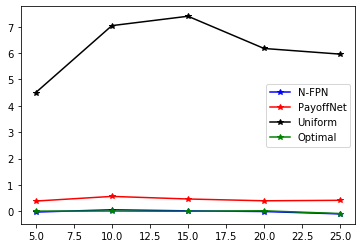

In [111]:
## Plot Results
sizes = np.arange(5,30,5)
fig1 = plt.figure(1)
plt.plot(sizes, mean_Cost_net1_array, label="N-FPN", color = 'blue', marker = '*')
# plt.fill_between(sizes, mean_Cost_net1_array - std_Cost_net1_array, mean_Cost_net1_array + std_Cost_net1_array, color = 'blue', alpha = .2)

plt.plot(sizes, mean_Cost_net2_array, label="PayoffNet", color = 'red', marker = '*')
# plt.fill_between(sizes, mean_Cost_net2_array - std_Cost_net2_array, mean_Cost_net2_array + std_Cost_net2_array, color = 'red', alpha = .2)

plt.plot(sizes, mean_Cost_uniform_array, label="Uniform", color = 'black', marker = '*')
# plt.fill_between(sizes, mean_Cost_uniform_array - std_Cost_uniform_array, mean_Cost_uniform_array + std_Cost_uniform_array, color = 'black', alpha = .2)

plt.plot(sizes, mean_Cost_optimal_array, label="Optimal", color = 'green', marker = '*')
# plt.fill_between(sizes, mean_Cost_optimal_array - std_Cost_optimal_array, mean_Cost_optimal_array + std_Cost_optimal_array, color = 'green', alpha = .2)

plt.legend()
plt.savefig('RPS_performance.pdf')
plt.show()



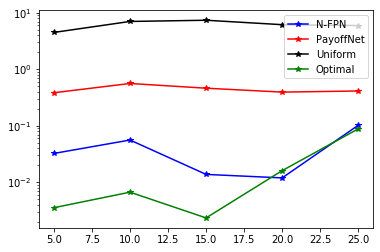

In [110]:
## Plot Results, log scale
fig1 = plt.figure(1)
plt.semilogy(sizes, np.abs(mean_Cost_net1_array), label="N-FPN", color = 'blue', marker = '*')
# plt.fill_between(sizes, mean_Cost_net1_array - std_Cost_net1_array, mean_Cost_net1_array + std_Cost_net1_array, color = 'blue', alpha = .2)

plt.semilogy(sizes, np.abs(mean_Cost_net2_array), label="PayoffNet", color = 'red', marker = '*')
# plt.fill_between(sizes, mean_Cost_net2_array - std_Cost_net2_array, mean_Cost_net2_array + std_Cost_net2_array, color = 'red', alpha = .2)

plt.semilogy(sizes, np.abs(mean_Cost_uniform_array), label="Uniform", color = 'black', marker = '*')
# plt.fill_between(sizes, mean_Cost_uniform_array - std_Cost_uniform_array, mean_Cost_uniform_array + std_Cost_uniform_array, color = 'black', alpha = .2)

plt.semilogy(sizes, np.abs(mean_Cost_optimal_array), label="Optimal", color = 'green', marker = '*')
# plt.fill_between(sizes, mean_Cost_optimal_array - std_Cost_optimal_array, mean_Cost_optimal_array + std_Cost_optimal_array, color = 'green', alpha = .2)

plt.legend()
plt.savefig('RPS_performance_logScale.pdf')
plt.show()